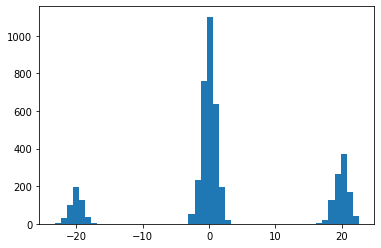

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from sampler import *
import pprint
from scipy.special import gammaln

# Generate test data.
y = np.concatenate([np.random.normal(-20, 1, 500),
                    np.random.normal(0, 1, 3000),
                    np.random.normal(20, 1, 1000)]).reshape(-1, 1)
mu_y = np.mean(y)
var_y = np.var(y)
nCustomers = len(y)

c = np.array([0]*500 + [1]*3000 + [2]*1000)
n = len(c)
plt.hist(y, bins=50)
plt.show()


In [2]:
k = 0 

In [3]:
def nCRP(alpha, gamma, nCustomers, assignments, tables):
    for i in range(len(assignments), nCustomers):
        # Probability of joining existing tables
        table_probs = [len(table) / (i + alpha) for table in tables]

        # Probability of starting a new table
        table_probs.append(alpha / (i + alpha))

        # Sample table assignment
        table = np.random.choice(len(tables) + 1, p=table_probs)

        if table == len(tables):
            # Start a new table
            tables.append([i])
            # Start a new assignment
            assignments.append([i])
        else:
            # Assign to an existing table
            tables[table].append(i)
            # Assign to an existing assignment
            assignments[table].append(i)

        if len(assignments[table]) > 1:
            # Recursively assign to lower level restaurants
            lower_assignments, lower_tables = nCRP(gamma, gamma, len(assignments[table]), assignments[table], tables[table])
            assignments[table] = lower_assignments
            tables[table] = lower_tables

    return assignments, tables


In [4]:
def cSampler (c, y, mu, s, alpha, lambda_, r, beta, omega, mu_prior, precision_prior, **kwargs):
    global k
    s_, mu_ = np.array(s), np.array(mu)
    n = len(c)
    nij = (n - np.array([c == j for j in range(k)])).T
    delta1 = (np.repeat(y, k, axis=1) - mu) ** 2
    delta1[np.isnan(delta1)] = 0
    probs1 = (nij / (n - 1 + alpha)) * (np.sqrt(s_/(2*np.pi)) * np.exp(-s_ * delta1 / 2))

    # Probabilities for the unrepresented components
    unrepresentedMu = np.random.normal(loc=mu_prior['mean'], scale=np.sqrt(1/mu_prior['precision']))
    unrepresentedPrecision = np.random.gamma(precision_prior['shape'], 1/precision_prior['scale'])
    delta2 = (y - unrepresentedMu) ** 2  
    delta2[np.isnan(delta2)] = 0
    likelihood = np.sqrt(unrepresentedPrecision) * np.exp(-unrepresentedPrecision * delta2 / 2) 
    probs2 = (alpha / (n - 1 + alpha)) * likelihood

    # Probabilities of the existing components concatenated with probability
    # for all the other components put together.
    probs = np.concatenate((probs1, probs2), axis=1)
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    probs[np.isnan(probs)] = 0

    # New Components sampled using those probabilities
    newC = np.array([np.argmax(rng.multinomial(1, pvals=pvals)) for pvals in probs])
    new_nj = np.array([np.sum(c == j) for j in range(k)])

    # Time to remove all those components who have no 
    # data point associated with them anymore!
    notClassLabels = np.array(range(k))[new_nj == 0]
    for label in notClassLabels : 
        newC[newC == label] = -1

    # Re-index the remaining component labels.
    classLabels = np.array(range(k))[new_nj > 0]
    mu.clear()
    mu.extend(mu_[new_nj > 0].tolist())
    s.clear()
    s.extend(s_[new_nj > 0].tolist())
    newK = sum(new_nj > 0)
    for i, label in enumerate(classLabels) :
        newC[newC == label] = i

    # If any data point is assigned one of the 
    # unrepresented classes, initialize a new class
    # with parameters mean and precision. 
    if sum(newC == k) > 0 : 
        newC[newC == k] = newK
        mu.append(unrepresentedMu)
        s.append(unrepresentedPrecision)
        k = newK + 1
    return newC


In [5]:

def meanSampler(assignments, y, s, lambda_, r, **kwargs):
    n = np.array([np.sum(assignments == j) for j in range(k)])
    y_sum = np.array([np.sum(y[assignments == j]) for j in range(k)])    
    ns = n*s
    mean = (y_sum * ns + lambda_ * r) / (ns + r)
    var = 1 / (ns + r)
    sample = rng.randn(k)
    return (mean + np.sqrt(var) * sample).tolist()

def precisionSampler(assignments, y, mu, beta, omega, **kwargs):
    n = np.array([np.sum(assignments == j) for j in range(k)])
    deltas = np.array([np.sum((y[assignments == j] - mu_j) ** 2) for j, mu_j in enumerate(mu)])
    shape = beta + n
    mean = ((deltas + omega * beta) / shape) ** (-1)
    scale = mean / shape
    return rng.gamma(shape, scale).tolist()

In [6]:

def lambdaSampler(assignments, mu, mu_y, var_y, r, **kwargs):
    if len(assignments)==0 or len(assignments[0])==0:
        return rng.randn() + mu_y
    current_means = [mu[j[-1]] for j in assignments]
    mean = (mu_y * 1 / var_y + r * np.sum(current_means)) / (1 / var_y + len(assignments) * r)
    var = 1 / (1 / var_y + len(assignments) * r)
    return mean + np.sqrt(var) * rng.randn()

def rSampler(assignments, mu, mu_y, var_y, lambda_, **kwargs):
    if len(assignments)==0 or len(assignments[0])==0:
        return 1.0
    current_means = [mu[j[-1]] for j in assignments]
    shape = len(assignments) + 1
    mean = ((1 / shape) * (var_y + np.sum((np.array(current_means) - lambda_) ** 2))) ** -1
    scale = mean / shape
    return rng.gamma(shape, scale)

def omegaSampler(s, var_y, beta, **kwargs):
    shape = len(s) * beta + 1
    mean = ((1 / shape) * (var_y + beta * np.sum(s))) ** -1
    scale = mean / shape
    return rng.gamma(shape, scale)

def betaSampler (s, omega, **kwargs) :
    s_ = np.array(s)
    def logU (y) :
        if k == 0 : 
            return y + (-3/2) * (y - math.log(2)) - (1/2) * torch.exp(-y)
        beta = torch.exp(y)
        t1 = (-k * torch.lgamma(beta/2))
        t2 = (-1/(2*beta))
        t3 = ((k*beta-3)/2)*(y - math.log(2))
        t4 = (beta/2)*np.sum(np.log(s_*omega) - s_*omega)
        return y + t1 + t2 + t3 + t4
    sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf)).pop()
    return np.exp(float(sample))

def alphaSampler (c, **kwargs) :
    n = len(c)
    def logU (y) :
        alpha = torch.exp(y)
        t1 = y * (k - (3/2))
        t2 = -1/(2 * alpha)
        t3 = torch.lgamma(alpha)
        t4 = -torch.lgamma(n + alpha)
        return y + t1 + t2 + t3 + t4
    #sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf)).pop()
    sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf)).pop()
    return np.exp(float(sample))


In [7]:
'''def metropolisHastingsSampler(logP, proposalSigma, nSamples):
    samples = []
    currentSample = 0.1  # Initial sample
    for _ in range(nSamples):
        proposedSample = currentSample + np.random.normal(0, proposalSigma)
        logAcceptanceRatio = logP(proposedSample) - logP(currentSample)
        if np.log(np.random.uniform()) < logAcceptanceRatio:
            currentSample = proposedSample
        samples.append(currentSample)
    return samples

def betaSampler(s, omega, **kwargs):
    proposalSigma = .1
    nSamples = 100
    def logP(beta):
        # Log-probability of beta distribution
        if k == 0:
            return (-3/2) * (beta - math.log(2)) - (1/2) * math.exp(-beta)
        return (-k * math.lgamma(beta/2)) + (-1/(2*beta)) + ((k*beta-3)/2)*(beta - math.log(2)) + (beta/2)*np.sum(np.log(s*omega) - s*omega)

    samples = metropolisHastingsSampler(logP, proposalSigma, nSamples)
    return np.exp(samples[-1])

def alphaSampler(c, s, **kwargs):
    proposalSigma = .1
    nSamples = 100

    n = len(c)
    def logP(alpha):
        # Log-probability of alpha distribution
        return alpha * (k - (3/2)) - (1/(2*alpha)) + math.lgamma(alpha) - math.lgamma(n + alpha)


    samples = metropolisHastingsSampler(logP, proposalSigma, nSamples)
    return np.exp(samples[-1])
'''

'def metropolisHastingsSampler(logP, proposalSigma, nSamples):\n    samples = []\n    currentSample = 0.1  # Initial sample\n    for _ in range(nSamples):\n        proposedSample = currentSample + np.random.normal(0, proposalSigma)\n        logAcceptanceRatio = logP(proposedSample) - logP(currentSample)\n        if np.log(np.random.uniform()) < logAcceptanceRatio:\n            currentSample = proposedSample\n        samples.append(currentSample)\n    return samples\n\ndef betaSampler(s, omega, **kwargs):\n    proposalSigma = .1\n    nSamples = 100\n    def logP(beta):\n        # Log-probability of beta distribution\n        if k == 0:\n            return (-3/2) * (beta - math.log(2)) - (1/2) * math.exp(-beta)\n        return (-k * math.lgamma(beta/2)) + (-1/(2*beta)) + ((k*beta-3)/2)*(beta - math.log(2)) + (beta/2)*np.sum(np.log(s*omega) - s*omega)\n\n    samples = metropolisHastingsSampler(logP, proposalSigma, nSamples)\n    return np.exp(samples[-1])\n\ndef alphaSampler(c, s, **kwarg

In [8]:
'''import scipy.stats as stats
from scipy.special import gamma
import random

def alphaSampler(c, gamma, **kwargs):
    n = len(c)
    alpha = 1 + gamma / n
    return random.gammavariate(alpha, 1)

def betaSampler(s, omega, **kwargs):
    k = len(s)
    beta = 2 * k + 2
    alpha = 1 / omega
    rate = alpha * np.sum(s)
    return stats.gamma.rvs(beta, scale=1 / rate)'''

'import scipy.stats as stats\nfrom scipy.special import gamma\nimport random\n\ndef alphaSampler(c, gamma, **kwargs):\n    n = len(c)\n    alpha = 1 + gamma / n\n    return random.gammavariate(alpha, 1)\n\ndef betaSampler(s, omega, **kwargs):\n    k = len(s)\n    beta = 2 * k + 2\n    alpha = 1 / omega\n    rate = alpha * np.sum(s)\n    return stats.gamma.rvs(beta, scale=1 / rate)'

In [9]:
mu_prior = {'mean': 0, 'precision': 1}
precision_prior = {'shape': 1, 'scale': 1}


In [10]:
parameters = {
    'alpha': 1,
    'mu': [],
    's': [],
    'lambda_': mu_y,
    'r': 1, 
    'beta': var_y,
    'omega': var_y,
    'c': np.ones(n) * -1
}

samplers = {
    'alpha': alphaSampler,
    'c': cSampler,
    'mu': meanSampler,
    's': precisionSampler,
    'lambda_': lambdaSampler,
    'r': rSampler, 
    'beta': betaSampler,
    'omega': omegaSampler
}

others = {
    'mu_y': mu_y,
    'var_y': var_y,
    'y': y,
    'gamma': 1.0,
    'mu_prior': mu_prior,
    'precision_prior': precision_prior
}


In [11]:
'''def GibbsSampler(num_iter, assignments, y, mu, s, alpha, lambda_, r, beta, omega, mu_prior, precision_prior, **kwargs):
    for iter in range(num_iter):
        assignments = cSampler(assignments, y, mu, s, alpha, lambda_, r, beta, omega, mu_prior, precision_prior)
        mu = meanSampler(assignments, y, s, lambda_, r)
        s = precisionSampler(assignments, y, mu, beta, omega)
        lambda_ = lambdaSampler(assignments, mu, mu_y, var_y, r)
        r = rSampler(assignments, mu, mu_y, var_y, lambda_)
        omega = omegaSampler(s, var_y, beta)
        beta = betaSampler(s, omega)
        alpha = alphaSampler(assignments)
    return assignments, y, mu, s, alpha, lambda_, r, beta, omega'''


'def GibbsSampler(num_iter, assignments, y, mu, s, alpha, lambda_, r, beta, omega, mu_prior, precision_prior, **kwargs):\n    for iter in range(num_iter):\n        assignments = cSampler(assignments, y, mu, s, alpha, lambda_, r, beta, omega, mu_prior, precision_prior)\n        mu = meanSampler(assignments, y, s, lambda_, r)\n        s = precisionSampler(assignments, y, mu, beta, omega)\n        lambda_ = lambdaSampler(assignments, mu, mu_y, var_y, r)\n        r = rSampler(assignments, mu, mu_y, var_y, lambda_)\n        omega = omegaSampler(s, var_y, beta)\n        beta = betaSampler(s, omega)\n        alpha = alphaSampler(assignments)\n    return assignments, y, mu, s, alpha, lambda_, r, beta, omega'

In [12]:
def gibbs(x, samplers, nSteps, assignments, tables, **kwargs):
    for i in tqdm(range(nSteps)):
        for k, v in x.items():
            if k in samplers:
                x[k] = samplers[k](**x, assignments=assignments, tables=tables, **kwargs)

        # Update nCRP at each iteration
        assignments, tables = nCRP(x['alpha'], kwargs['gamma'], len(y), assignments, tables)
        
    return x


In [13]:
assignments, tables = [[]]*nCustomers, [[]]*nCustomers

inferredParameters = gibbs(parameters, samplers, 100, assignments, tables, **others)


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

  8%|▊         | 8/100 [00:01<00:13,  6.78it/s]/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_73658/1078767866.py:21: RuntimeWarning: invalid value encountered in true_divide
  probs = probs / np.sum(probs, axis=1, keepdims=True)
100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


In [14]:

pprint.PrettyPrinter(indent=2).pprint(inferredParameters)

{ 'alpha': 0.600667197467481,
  'beta': 15517.34200080539,
  'c': array([4, 4, 4, ..., 4, 4, 4]),
  'lambda_': 2.2160681966894646,
  'mu': [ 0.7927726701379959,
          1.8548170116871836,
          1.1709604967767924,
          1.0761900360662855,
          0.9081563502837218],
  'omega': 0.004877560896221558,
  'r': 1.0,
  's': [ 206.26371878566258,
         207.41761631329527,
         205.29294501199692,
         205.55886194133424,
         0.9212510057343364]}


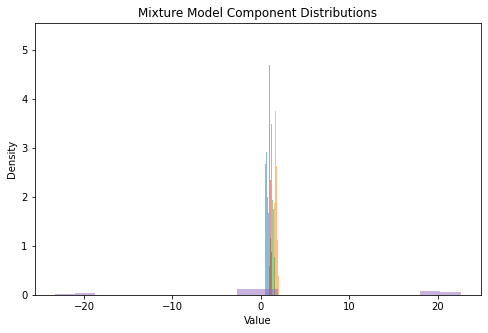

In [15]:

c = inferredParameters['c']
mu = inferredParameters['mu']
s = inferredParameters['s']

k = len(mu)


plt.figure(figsize= (8, 5))

for j in range(k):
    component_data = y[c == j] 
    plt.hist(component_data, bins=20, density=True, alpha=0.5, label=f'Component {j+1}')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Mixture Model Component Distributions')
#plt.legend()
plt.show()

In [16]:
k

5

In [17]:
def logU (y) :
        alpha = torch.exp(y)
        t1 = y * (k - (3/2))
        t2 = -1/(2 * alpha)
        t3 = torch.lgamma(alpha)
        t4 = -torch.lgamma(n + alpha)
        return y + t1 + t2 + t3 + t4